In [58]:
import math
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from pandas import Series, DataFrame
import pandas as pd
import nltk
%pylab inline 


Populating the interactive namespace from numpy and matplotlib


In [51]:
jobs = pd.read_csv("../Data/train_rev1.csv") # 244,768 records
jobs_sample = jobs.sample(1000) # 1,000 records

In [52]:
tokenizer = RegexpTokenizer(r'\w+') #Tokenizes and removes punctuation

#Strip and decode FullDescription column so we can tokenize it
jobs_sample['tokenized_strip'] = jobs_sample.apply(lambda row: row['FullDescription'].decode('utf-8').strip(),axis=1)
jobs_sample['tokenized'] = jobs_sample.apply(lambda row: tokenizer.tokenize(row['tokenized_strip']),axis=1)

In [53]:
#Combine each row of tokens into one list
tokens_series = pd.Series(jobs_sample['tokenized'])
tokens_list = tokens_series.tolist()

tokens = []
for sentence in tokens_list:
    for word in sentence:
        tokens.append(word)

In [54]:
#Run pos_tag on full list of tokens now
tokens_pos = nltk.pos_tag(tokens)

### Most Common POS

In [55]:
#Unzips the tuples
words, pos = zip(*tokens_pos)
pos_freq = FreqDist(pos)
pos_freq.most_common()[:5] #Most frequent POS's

## NN corresponds to noun
## NNP corresponds to proper noun, singular
## IN corresponds to preposition or subordinating conjunction
## JJ corresponds to adjective
## DT corresponds to determiner
## https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

[('NN', 47190), ('NNP', 36618), ('IN', 26739), ('JJ', 21535), ('DT', 20493)]

### Most Common POS' Frequencies

In [56]:
for a, b in pos_freq.most_common()[:5]:
    print a, b * 1.0 / len(pos) * 1.0 #Most common POS' frequencies

NN 0.187095597564
NNP 0.145180474499
IN 0.10601290916
JJ 0.0853804554682
DT 0.081249207054


### Zipf's Law

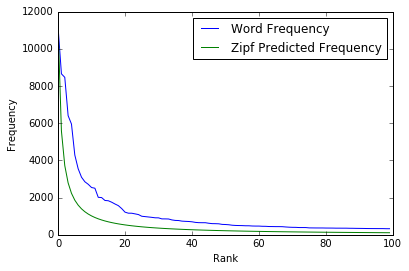

In [57]:
words_lower = []
for word in words:
    words_lower.append(word.lower())
    
word_freq = FreqDist(words_lower)
most_common_words = word_freq.most_common()[:100]

n = most_common_words[0][1]
nums = []
nums.append(n)
counter = 1
while len(nums) < 100:
    counter += 1
    nums.append(n * (1.0/counter))


# Plot actual frequencies and Zipf frequencies
plot([b for (a,b) in most_common_words], label = 'Word Frequency') # Blue
plot(nums, label = 'Zipf Predicted Frequency') # Green
legend(loc='best')
xlabel('Rank')
ylabel('Frequency')

### A3

In [37]:
filtered_words = [word for word in words_lower if word not in stopwords.words('english')]


# Part B

### One Feature: Length of Description

In [59]:
import numpy as np

jobs_b = jobs[['FullDescription', 'SalaryNormalized']]
jobs_b_sample = jobs_b.sample(5000)

In [11]:
descriptions = []
pay = []

for index, value in jobs_b_sample.iterrows():
    descriptions.append(value['FullDescription'])
    pay.append(value['SalaryNormalized'])
    
perc_75 = np.percentile(pay, 75)
    
content = zip(descriptions, pay)

In [12]:
def find_pay_bin(pay):
    return pay >= perc_75

In [13]:
def description_length(desc):
    return {'description_length': len(desc)}

feature_sets = [(description_length(desc), find_pay_bin(pay)) for (desc, pay) in content]

train_set = feature_sets[2500:]
test_set = feature_sets[:2500]

classifier = nltk.NaiveBayesClassifier.train(train_set)

nltk.classify.accuracy(classifier, test_set)

0.69320000000000004

### One Feature: Words in Description

In [14]:
def description_word_length(desc):
    return {'description_word_length': len(desc.split())}

feature_sets = [(description_word_length(desc), find_pay_bin(pay)) for (desc, pay) in content]

train_set = feature_sets[2500:]
test_set = feature_sets[:2500]

classifier = nltk.NaiveBayesClassifier.train(train_set)

nltk.classify.accuracy(classifier, test_set)

0.71840000000000004

### Bag of Words

In [15]:
tokenized_strip = pd.Series(jobs_sample['tokenized_strip'])
strip_list = tokenized_strip.tolist()

In [16]:
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None)

job_features = vectorizer.fit_transform(strip_list)

job_features = job_features.toarray()

vocab = vectorizer.get_feature_names()

dist = np.sum(job_features, axis=0)

In [17]:
bag_zip = zip(vocab, dist)

In [18]:
bag_dict = {}

for vocab, dist in bag_zip:
    bag_dict[vocab] = dist